In [88]:

import numpy as np
import struct
import math
import OpenEXR
import Imath
import array
import matplotlib.pyplot as plt

# bin 文件读取
def load_bin(filename, size, ds=4, dtype='f'):
    """
    read a matrix which is saved in binary file

    Args:
    - size: matrix size, for example: (10000, 2)
    - ds: data type size (bytes)
    """
    with open(filename, 'rb') as f:
        data = np.zeros(size)
        with np.nditer(data, op_flags=['readwrite']) as it:
            for x in it:
                x[...] = struct.unpack(dtype, f.read(ds))[0]

    return data

# exr 文件读取
def load_image(path, to_tensor=True):
    """
    read .exr image and convert to ndarray.

    Args:
    - path: .exr image path

    Returns:
    - tensor: C × H × W, range [0, ???] or ndarray: H × W × C range [0, ???]
    """
    file = OpenEXR.InputFile(path)
    # Compute the size
    dw = file.header()['dataWindow']
    sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)     # width height
    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)

    (R, G, B) = [np.array(array.array('f', file.channel(Chan, FLOAT)).tolist(), dtype=np.float32).reshape(sz[1], sz[0]) for Chan in ("R", "G", "B") ]
    image = np.dstack((R, G, B))
    
    # image = cv2.imread(path)

    if to_tensor:
        data = im_to_torch(image)
    else:
        data = image
    return data

def CEToneMapping(img, adapted_lum):
    return 1 - np.exp(-adapted_lum * img)

def im_to_numpy(img):
    """
    convert tensor image to ndarray

    Args:
    - img: tensor, C × H × W

    Returns:
    - img: ndarray,  H × W × C
    """
    if type(img) is np.ndarray:
        return img
    img = to_numpy(img)
    img = np.transpose(img, (1, 2, 0))  # H*W*C
    return img

def imshow(img, tone_mapping=True):
    """
    display image with tone mapping
    
    Args:
    - img: tensor C × H × W, range [0, 1], or ndarray H × W × C
    """
    fig=plt.figure()
    tmp = img
    if tone_mapping:
        tmp = CEToneMapping(tmp, 3)
    npimg = im_to_numpy(tmp * 255).astype(np.uint8)
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

坐标系: 竖着的是 z 轴, 横轴是 y, 朝外的是 x 轴.

假设物体在旋转，那么光源位置是固定的，相机的位置也是固定的。
- `light_8x8.bin`: 光源位置
- 相机位置: `[353.068, 0.833654, 316.206]`

物体每次旋转后的信息:
- gutter_map: 可见的 texel
- position_origin.bin(num × 3) : gutter_map 中每个 texel 的 3D 坐标
- normal_map: 旋转后法线也会变


### 光源 lights_8x8.bin

假设物体在旋转, 那么光源的位置是固定的

In [16]:
light = load_bin("D:\\Code\\Project\\NeuralTexture_gan\\data\\lights_8x8.bin", (2, 384, 3))

for i in range(0, 12):
    light_pos = light[0][i]
    light_dir = light[1][i]

    print (i, light_pos, light_dir)

0 [ 336.53512573 -308.00872803 -243.82110596] [0.99981856 0.00323772 0.01877211]
1 [ 336.28863525 -228.01187134 -244.48551941] [0.99981844 0.00323487 0.01877596]
2 [ 336.04211426 -148.01496887 -245.1499176 ] [0.99981844 0.00323486 0.01877759]
3 [ 335.79559326  -68.01810455 -245.81442261] [0.9998185  0.00323486 0.01877523]
4 [ 335.03106689 -307.34902954 -163.83795166] [0.9998185  0.00323677 0.01877309]
5 [ 334.7845459  -227.35220337 -164.50236511] [0.9998185  0.00323486 0.01877306]
6 [ 334.5380249  -147.35528564 -165.16687012] [0.9998185  0.00323486 0.01877309]
7 [ 334.29156494  -67.3584137  -165.83122253] [0.9998185  0.00323486 0.01877403]
8 [ 333.52713013 -306.68875122  -83.8540802 ] [0.9998185  0.00323724 0.01877544]
9 [ 333.28060913 -226.69186401  -84.51850891] [0.9998185  0.00323487 0.01877464]
10 [ 333.03408813 -146.69500732  -85.18293762] [0.9998185  0.00323486 0.0187752 ]
11 [332.78762817 -66.69813538 -85.84736633] [0.9998185  0.00323486 0.01877534]


### gutter_map

In [7]:
idx = 1

gutter_map = load_image('D:\\Code\\Project\\NeuralTexture_gan\\data\\gt\\{}\\result1024\\gutter_map.exr'.format(idx), False)
print (gutter_map.shape)
# print (type(gutter_map))

print (np.sum(gutter_map[:, :, 0] > 0))

pos = np.argwhere(gutter_map[:, :, 0] > 0)


(1024, 1024, 3)
311838


### normal

注意法向量物体旋转后是不同的

In [100]:
normal_map = load_image('D:\\Code\\Project\\NeuralTexture_gan\\data\\gt\\{}\\result1024\\normal_geo_gloabl.exr'.format(idx), False)

normal_map = (normal_map - 0.5) * 2     # [-1, 1]
print (normal_map.shape)
print (normal_map.min())
print (normal_map.max())

(1024, 1024, 3)
-1.0
1.0


### positions_origin

每个 texel 的 3D 坐标

[[ 30.54101372  15.80316639 -28.64683533]
 [ 30.46201897  15.87378216 -28.64429283]
 [ 30.38302231  15.94439602 -28.64174843]
 [ 30.27265549  16.01622391 -28.64884567]
 [ 30.16108513  16.07851791 -28.66011238]
 [ 29.71330643  16.12202835 -28.50695229]
 [ 29.03303528  16.07982826 -28.11367798]
 [ 28.99403954  16.066185   -28.05376244]
 [ 28.96946526  16.05210495 -28.00031662]
 [ 28.94507408  16.03812599 -27.94726944]]
(311838, 3)


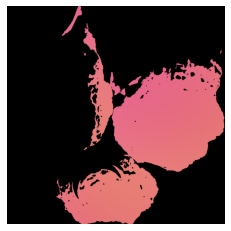

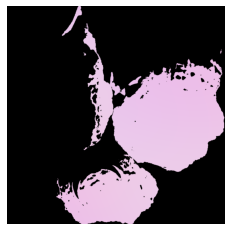

In [91]:
positions_origin = load_bin("D:\\Code\\Project\\NeuralTexture_gan\\data\\gt\\{}\\result1024\\positions_origin.bin".format(idx), (pos.shape[0], 3))


# position_map = np.zeros((1024, 1024, 3))        # 每个 texel 世界空间坐标

light_dir_map = -np.ones((1024, 1024, 3))
view_dir_map = -np.ones((1024, 1024, 3))

print (positions_origin[10:20, :])

light_dir = light[0][0] - positions_origin
view_dir = np.array([353.068, 0.833654, 316.206]) - positions_origin


light_dir = light_dir / np.sqrt(np.sum(light_dir * light_dir, axis=1, keepdims=True))
view_dir = view_dir / np.sqrt(np.sum(view_dir * view_dir, axis=1, keepdims=True))

print (light_dir.shape)

for i, p in enumerate(pos):

    light_dir_map[p[0], p[1]] = light_dir[i]
    view_dir_map[p[0], p[1]] = view_dir[i]

imshow((light_dir_map+1)/2)
imshow((view_dir_map+1)/2)

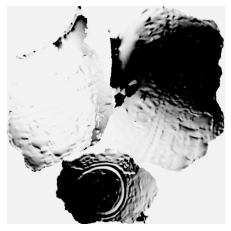

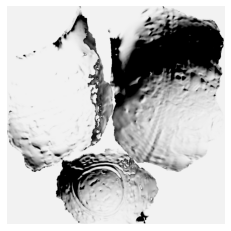

In [108]:
cos_light_map = np.sum(light_dir_map * normal_map, axis=2, keepdims=True)
cos_view_map = np.sum(view_dir_map * normal_map, axis=2, keepdims=True)

cos_light_map = np.clip(cos_light_map, 0, 1)
cos_view_map = np.clip(cos_view_map, 0, 1)

imshow(cos_light_map.repeat(3, 2))
imshow(cos_view_map.repeat(3, 2))

In [97]:
print (light_dir_map[0, 0, :])
print (normal_map[0, 0, :])

[-1. -1. -1.]
[0. 0. 0.]
